In [7]:
import random
from collections import defaultdict

import gym
import gym.spaces as spaces
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator
import pandas as pd
import torch   
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam    
from torch.utils.data import DataLoader, Dataset
# import stable_baselines3 as sb3

from envs.robots.robot_arm import RobotArm
from supervised.data import \
    TargetGaussianDataset as SupervisedTargetGaussianDataset
from supervised.data import YMode
from supervised.loss import PointDistanceLoss, IKLoss
from supervised.utils import forward_kinematics
from vae.data.load_data_set import TargetGaussianDataset

In [8]:
n_joints = 5
device = "cuda:0"

In [9]:
df_start = pd.read_csv(f"datasets/{n_joints}/train/state_IK_random_start.csv")
df_action = pd.read_csv(f"datasets/{n_joints}/train/actions_IK_random_start.csv")

In [4]:
class WrapperDataset(Dataset):
    def __init__(self, path, supervised=True) -> None:
        if supervised:
            self.data = SupervisedTargetGaussianDataset(path, 0.2)
        else:
            self.data = TargetGaussianDataset(path, 0.2)
        self.supervised = supervised

    def __getitem__(self, idx):
        if self.supervised:
            x, y = self.data[idx]
            x = x.detach()
            return x, y

        x, cond_enc, cond_dec, y = self.data[idx]
        x = torch.cat([x, cond_enc.detach()])
        # x: delta to target, curr pos, curr angles
        return x, y
    
    def __len__(self):
        return len(self.data)
    

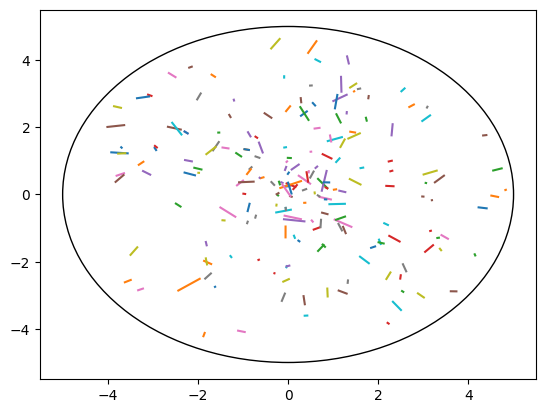

In [10]:
dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv", supervised=True)

fig, axs = plt.subplots()
axs.add_patch(plt.Circle((0, 0), n_joints, fill=False))
for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    plt.plot(data[:, 0], data[:, 1])

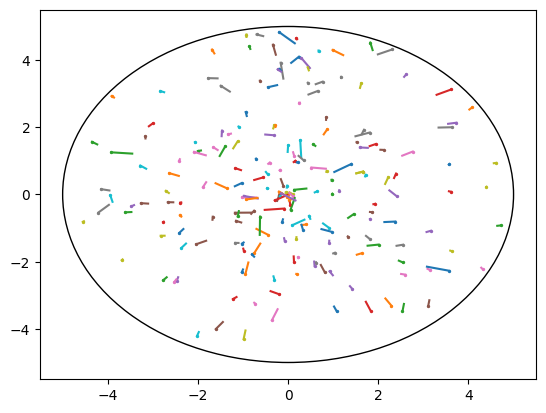

In [11]:
dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv", supervised=False)

fig, axs = plt.subplots()
axs.add_patch(plt.Circle((0, 0), n_joints, fill=False))
for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4].detach()
    target_pos = y.detach()
    data = np.stack([curr_pos, target_pos])
    axs.plot(data[:, 0], data[:, 1])
    axs.scatter(curr_pos[0], curr_pos[1], s=2)

##### Question: What is happening in the plot above?

Because there is an implementation error to correct noise which lies outside the robots reach. Fixed in the latest version of the supervised dataset version

In [12]:
model = nn.Sequential(
    nn.Linear(4 + n_joints, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, n_joints),
).to(device)
optim = Adam(model.parameters(), lr=0.0003)

In [13]:
EPOCHS = 100
train_dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv")
train_loader = DataLoader(train_dataset, 32)
val_dataset = WrapperDataset(f"datasets/{n_joints}/val/state_IK_random_start.csv")
val_loader = DataLoader(val_dataset, 256)



# def loss_fn(angles, y):
#     pos = forward_kinematics(angles)[:, -1]
#     return F.huber_loss(pos, y)
# 
# loss_fn = PointDistanceLoss("cpu")

loss_fn = IKLoss(0, 1, 0, YMode.POSITION)

stats = defaultdict(list)
                

for idx in range(EPOCHS):
    train_losses = []

    for x, y in train_loader:
        x = x.to(device)
        angles = x[:, 4:] + torch.tanh(model(x)) 
        loss = loss_fn(y, angles)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    with torch.no_grad():
        stats["val_loss"].append(np.mean([loss_fn(y, x[:, 4:].to(device) + torch.tanh(model(x.to(device)))).item() for x, y in val_loader]))
    stats["train_loss"].append(np.mean(train_losses))

    if idx % 10 == 0:
        print("train loss: ", stats["train_loss"][-1], "val_loss: ", stats["val_loss"][-1])


train loss:  0.1556322943097867 val_loss:  0.1372820846736431
train loss:  0.04601623908804057 val_loss:  0.052362087182700634
train loss:  0.030858785158005386 val_loss:  0.03701567929238081
train loss:  0.025069063365721282 val_loss:  0.024180566193535924
train loss:  0.02166832261644423 val_loss:  0.021669806446880102
train loss:  0.019658417812884806 val_loss:  0.022130593890324235
train loss:  0.017429744539121852 val_loss:  0.020907403668388724
train loss:  0.015781300201916846 val_loss:  0.0176375568844378
train loss:  0.015052246429716436 val_loss:  0.016871680971235037
train loss:  0.01414441780303233 val_loss:  0.017232157289981842


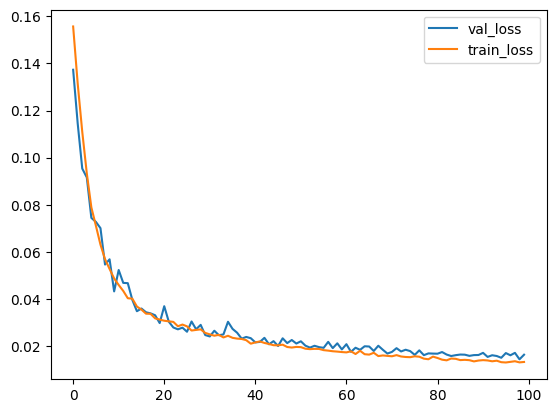

In [14]:
plt.plot(stats["val_loss"], label="val_loss")
plt.plot(stats["train_loss"], label="train_loss")
plt.legend()

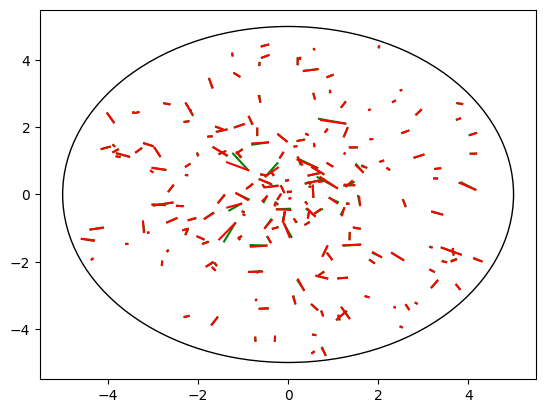

In [15]:
dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv")

fig, axs = plt.subplots()
axs.add_patch(plt.Circle((0, 0), n_joints, fill=False))
for x, y in random.choices(dataset, k=200):
    x = x.to(device)
    with torch.no_grad():
        pred = (x[4:] + torch.tanh(model(x)))[None, :]

    model_pos = forward_kinematics(pred)[0, -1]
    curr_pos = x[2: 4].cpu()
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    data_pred = np.stack([curr_pos, model_pos])
    axs.plot(data[:, 0], data[:, 1], color="green", label="ground truth")
    axs.plot(data_pred[:, 0], data_pred[:, 1], color="red", label="pred")
    

### RL Env

In [16]:


def sample_pt(rng: Generator, n: int):
    phi = rng.uniform(0, 2 * np.pi)
    scale = rng.uniform(0, n)
    return np.array([scale * np.cos(phi), scale * np.sin(phi), 1])

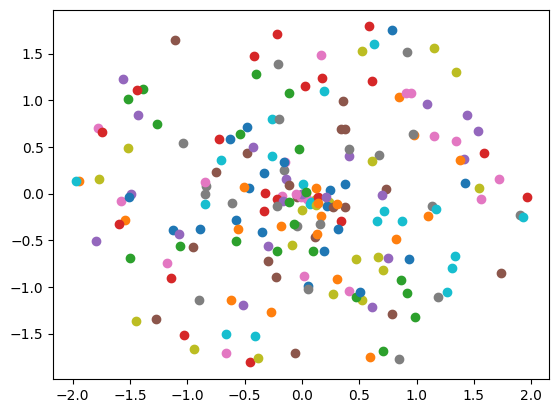

In [17]:
rng = np.random.default_rng(0)

for _ in range(200):
    plt.scatter(*sample_pt(rng, 2)[: 2])

In [18]:


# label_angles, _, _, _ = IK(
#     new_target,
#     np.rad2deg(state_angles[state_idx]).copy(),
#     np.ones_like(state_angles[state_idx]),
#     err_min=0.001)

arm = RobotArm(2)
target = sample_pt(rng, 2)
print(arm.end_position)
arm.IK(target, error_min=0.001)
print(arm.end_position)
print(target)

[2. 0.]
[0.55535459 1.79076648]
[0.55530158 1.79173216 1.        ]


In [37]:
class Army(gym.Env):
    def __init__(self, n=2, model=None):
        super().__init__()
        self.n = n
        self.model = model
        self.eps = 0.1
        self.max_steps = 100

        self.rng = np.random.default_rng(0)
        self.arm = RobotArm(n)
        self.target_pos = None
        self.curr_step = 0

        dim = 4 + self.n
        self.observation_space = spaces.Box(np.full(dim, -np.inf), np.full(dim, np.inf))
        cons = np.array([0.3, 0.3])
        self.action_space = spaces.Box(-cons, cons)

    def seed(self, seed: int = 0):
        self.rng = np.random.default_rng(seed)

    def obs(self):
        return np.concatenate(
            [self.target_pos[:2], self.arm.positions[-1], self.arm.angles]
        )

    def reset(self):
        start_pos = sample_pt(self.rng, self.arm.n_joints)
        arm.IK(start_pos, error_min=0.001)
        self.target_pos = sample_pt(self.rng, self.arm.n_joints)
        
        self.curr_step = 0
        return self.obs()

    def step(self, action):
        obs = np.concatenate([action, self.obs()[2:]])
        obs = torch.from_numpy(obs)[None, :].float()
        state_angles = obs[0, 4:]
        with torch.no_grad():
            angle = state_angles + torch.tanh(self.model(obs)[0]).numpy()

        self.arm.set(angle)
        distance = np.linalg.norm(self.target_pos[:2] - self.arm.end_position)
        done = True if distance < self.eps else False

        self.curr_step += 1
        if self.curr_step == self.max_steps:
            done = True

        return self.obs(), -distance, done, {}

    def render(self, fig=None, ax=None, color="k"):
        if fig is None or ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.set_xlim([- self.n -0.2, self.n + 0.2])
        ax.set_ylim([- self.n -0.2, self.n + 0.2])
        ax.scatter(*self.target_pos[:2])

        for p1, p2 in zip(self.arm.positions, self.arm.positions[1:]):
            data = np.stack([p1, p2])
            ax.plot(data[:, 0], data[:, 1], color=color, marker=".", alpha=2 / 5)

        return fig, ax

    def direction(self, max_length=0.4):
        delta = self.target_pos[:2] - self.arm.end_position
        norm = np.linalg.norm(delta, 2)
        scaling = 1 if norm < max_length else max_length / norm
        return scaling * delta

/home/uhrich/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


[2.92691914 3.73249765]
-3.8087881132029553 False
-3.438932658773125 False
-3.102938966904603 False
-2.804253818280691 False
-2.5296753676318295 False
-2.2656051394634984 False
-2.000879170572753 False
-1.716175816721627 False
-1.2619360041207321 False
-0.8303777189008418 False
-0.4837074415464441 False
-0.4846233473768092 False
-0.8030359139719387 False
-1.2517608238236089 False
-1.7537735046756888 False
-2.290912799656385 False
-2.2568137015342344 False
-2.24199909492875 False
-2.2433061179276303 False
-2.2592541177379273 False
-2.2890583643523943 False
-2.330660322592308 False
-2.381959056754497 False
-2.440411329970048 False
-2.504276180898913 False
-2.571883445921685 False
-2.641887034700594 False
-2.7132566706836965 False
-2.785089331605572 False
-2.8566231298944476 False
-2.9275504647859076 False
-2.9982383055936124 False
-3.0683740768365806 False
-3.1377643052174076 False
-3.206482969269874 False
-3.2733316445700305 False
-3.3374666562828614 False
-3.398124173168803 False
-3.45

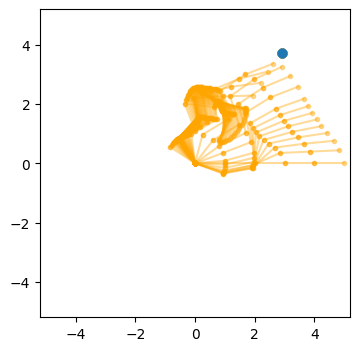

In [38]:
seed = 1

color = "orange"

env = Army(model=model.to("cpu"), n=n_joints)
env.seed(seed)
obs = env.reset()
fig, ax = env.render(color=color)
done = False

rewards = []
print(obs[:2])
for _ in range(50):
    direction = env.direction()
    obs, reward, done, info = env.step(direction)
    print(reward, done)
    rewards.append(reward)
    env.render(fig, ax, color=color)

    if done:
        break

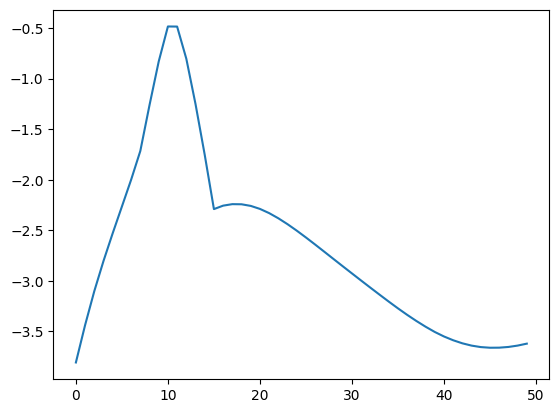

In [39]:
plt.plot(rewards)

In [47]:
import stable_baselines3 as sb3

alg = sb3.SAC("MlpPolicy", env, verbose=1)
alg.learn(50000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -309     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 40       |
|    time_elapsed    | 9        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 2.05     |
|    critic_loss     | 0.149    |
|    ent_coef        | 0.914    |
|    ent_coef_loss   | -0.299   |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -339     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 38       |
|    time_elapsed    | 20       |
|    total_timesteps | 800      |
| train/             

/home/uhrich/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


-5.204456310138179 False
-5.03792038525977 False
-4.934004090552963 False
-4.781776568217333 False
-4.693854000665127 False
-4.596915336598034 False
-4.442699683132169 False
-4.249180187837748 False
-4.048967827804937 False
-3.868335732589008 False
-3.672424651779914 False
-3.5604197868621794 False
-3.320538134398927 False
-3.0812487105463946 False
-2.8747937480180985 False
-2.6377202299638887 False
-2.4979880302776056 False
-2.3727573897989114 False
-2.1773336529440406 False
-2.136735398544932 False
-1.951319257970832 False
-1.8269198413548675 False
-1.688813986916938 False
-1.7058243630869623 False
-1.5480366084308133 False
-1.7089390843670957 False
-1.4963612368933665 False
-1.6099182240017982 False
-1.747802811168838 False
-1.619854172461945 False
-1.627444481181946 False
-1.5795923096905848 False
-1.5763423824438412 False
-1.6318973409044253 False
-1.3667989923009483 False
-1.3638367477288604 False
-1.4129394631140229 False
-1.2993325839478476 False
-1.2826277683946332 False
-1.27

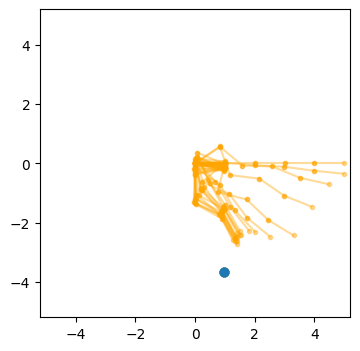

In [46]:
seed = 1
color = "orange"

env = Army(model=model, n=n_joints)
env.seed(seed)
for _ in range(np.random.randint(0, 100)):
    obs = env.reset()
fig, ax = env.render(color=color)
done = False

rewards = []
for i in range(100):
    direction, _ = alg.policy.predict(obs)
    # print(direction)
    obs, reward, done, info = env.step(direction)
    print(reward, done)
    if i % 5 == 0:
        env.render(fig, ax, color=color)
    rewards.append(reward)
    if done:
        break

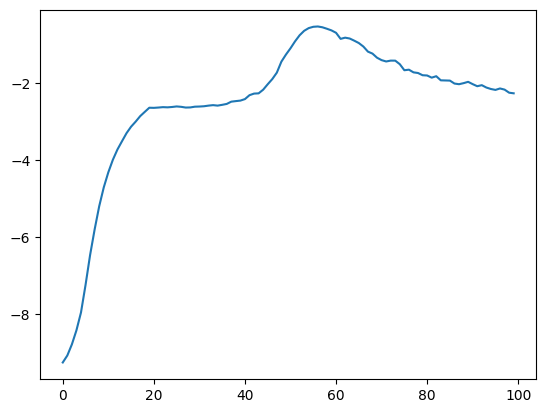

In [45]:
plt.plot(rewards)